# BHP share price EDA and model prediction

In [1]:
import numpy as np
import pandas as pd
import datetime
import fred
#Fred 44c14dd1fb4c61edfeb543d5b3e00562
from yahoo_fin.stock_info import get_data
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt

# 1.Data collection

In [2]:
# Fred is a python library that can connect to FRED (Federal Reserve Bank of St Louise) databases via FRED API
# To use Fred, you need to obtain a key from FRED https://fred.stlouisfed.org/docs/api/fred/

fred.key('44c14dd1fb4c61edfeb543d5b3e00562')

In [3]:
# Getting the copper price from FRED
copper = fred.observations('PCOPPUSDM'.lower()) 

In [4]:
# Transform the data format from jason to series
from pandas import json_normalize
df = json_normalize(copper['observations'])
copper = df[df['value']!='.'][['date','value']]
copper['date'] = pd.to_datetime(copper['date'],format='%Y/%m/%d')
#copper['Month'] = copper['date'].apply(lambda x:x.month)
#copper['Year'] = copper['date'].apply(lambda x:x.year)

In [5]:
# apply the same method to data collection of iron ore 
ironore = fred.observations('PIORECRUSDM'.lower())
ironore = json_normalize(ironore['observations'])
ironore = ironore[ironore['value']!='.'][['date','value']]
ironore['date'] = pd.to_datetime(ironore['date'],format='%Y/%m/%d')

In [6]:
# Obtain Aus dollar/US dollar price from yahoo finance;Obtain Bhp share price price from yahoo finance
bhp = get_data("BHP.AX", start_date="01/01/2000", interval="1mo")

In [7]:
# Creating a new feature of green candle
bhp['green_candle'] = bhp['close'] < bhp['open']

In [8]:
# Getting the data of exchange rate of aud to usd
aud_usd = get_data("AUDUSD=X", start_date="01/01/2000", interval="1mo")

In [9]:
bhp.index = bhp.index.strftime('%Y-%m')

In [10]:
#check if there are any duplicate values
aud_usd.index.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [11]:
aud_usd.index = aud_usd.index.strftime('%Y-%m')

In [12]:
aud_usd.index.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,

In [13]:
aud_usd = aud_usd.groupby(aud_usd.index).mean()

In [14]:
bhp

,open,high,low,close,adjclose,volume,ticker,green_candle
1999-12,8.317775,9.153254,7.685240,7.795445,3.160395,175817747,BHP.AX,True
2000-01,7.827466,7.943078,6.587348,6.692147,2.713100,207517907,BHP.AX,True
2000-02,6.691315,7.772572,6.487540,7.419916,3.008149,243243412,BHP.AX,False
2000-03,7.464830,7.901491,7.000305,7.668605,3.108971,123009177,BHP.AX,False
2000-04,7.568797,7.902323,6.820234,7.406608,3.002754,152583611,BHP.AX,True
...,...,...,...,...,...,...,...,...
2022-06,40.830002,40.840000,35.830002,38.680000,36.248840,217257743,BHP.AX,True
2022-07,39.110001,43.070000,37.919998,40.599998,38.048161,222071331,BHP.AX,False
2022-08,37.500000,39.770000,36.130001,38.520000,36.098896,261005300,BHP.AX,False
2022-09,39.040001,40.849998,37.349998,37.480000,37.480000,188783188,BHP.AX,True


In [15]:
#Join the dataframe first for later merging
bhp['aud_to_usd'] = aud_usd['close']

# 2. Data preprocessing

## 2.1 merging data frames

In [16]:
# Create a new data frame by joining iron ore and copper data frames
df = ironore.merge(copper, on='date')

In [17]:
# Extract date feature from bhp data frame index
bhp['date'] = bhp.index

In [18]:
# Transform the date such that BHP date format is the same as the date format of copper and iron date format
# The final date format is String
df['date'] = df['date'].dt.strftime('%Y-%m')

In [19]:
#joining bhp dataframe and copper/ironore data frame, name the merged dataframe as "df"
df = df.merge(bhp[['close','aud_to_usd','date','green_candle']], on='date')

In [20]:
# rename the features
df.columns = ['date', 'ironore', 'copper','bhp_price','aud_to_usd','green_candle']

In [21]:
# calculate iron ore price in AUD
df['ironore'] = df['ironore'].astype(float)
df['copper'] = df['copper'].astype(float)
df['ironore_aud_price'] = df['ironore']/df['aud_to_usd']
df['copper_aud_price'] = df['copper']/df['aud_to_usd']

In [22]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m')

## 2.2 Dealing with missing values

In [23]:
df[df.date>='2006-05'].isnull().sum()

date                  0
ironore               0
copper                0
bhp_price             0
aud_to_usd           16
green_candle          0
ironore_aud_price    16
copper_aud_price     16
dtype: int64

In [24]:
# delete the empty data, and rename the new data frame as "df_delete"
df_delete = df.dropna()
#use pearson correlation as feature importance , and see which feature is most important
#normally a value less than 0.2 is considered not correlated
from scipy.stats import pearsonr

print(pearsonr(df_delete['copper'], df_delete['bhp_price']))
print(pearsonr(df_delete['ironore'], df_delete['bhp_price']))
print(pearsonr(df_delete['ironore_aud_price'], df_delete['bhp_price']))
print(pearsonr(df_delete['copper_aud_price'], df_delete['bhp_price']))

(0.665101044778676, 2.375648372408537e-24)
(0.6302522214488959, 2.5544115462421523e-21)
(0.6685831118712398, 1.1228699656790017e-24)
(0.6098878058756105, 1.0175688276239854e-19)


In [17]:
# in stead of deleting, we replace each feature's empty values with population median

#df['aud_to_usd'] =df['aud_to_usd'].replace(np.nan,df['aud_to_usd'].median())
#df['bhp_price'] =df['bhp_price'].replace(np.nan,df['bhp_price'].median())
#df['ironore_aud_price'] =df['ironore_aud_price'].replace(np.nan,df['ironore_aud_price'].median())
#df['copper_aud_price'] =df['copper_aud_price'].replace(np.nan,df['copper_aud_price'].median())

In [25]:
df = df.dropna()

<AxesSubplot:xlabel='ironore_aud_price', ylabel='Count'>

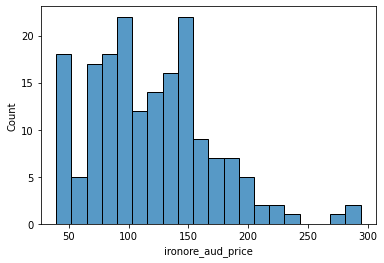

In [26]:
# Histogram of iron ore price before any scaling 

sns.histplot(data=df, x="ironore_aud_price",bins=20)

## 2.3 Scaling the data

In [27]:
# Histogram of iron ore price after normalisation 

x_array = np.array(df['ironore_aud_price'])
normalized_arr = preprocessing.normalize([x_array])
df['normalized_iron_aud']=normalized_arr[0]


x_array = np.array(df['copper_aud_price'])
normalized_arr = preprocessing.normalize([x_array])
df['normalized_copper_aud']=normalized_arr[0]

<AxesSubplot:xlabel='normalized_iron_aud', ylabel='Count'>

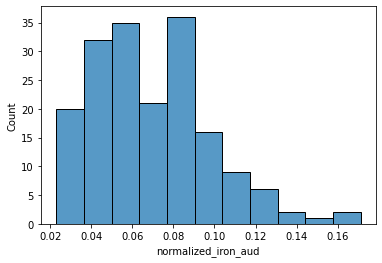

In [28]:
sns.histplot(data=df, x="normalized_iron_aud")

In [29]:
#Histogram of iron ore price after min max scaling 
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(df[['ironore_aud_price','copper_aud_price']])
scaled_df = pd.DataFrame(d, columns=['ironore_aud_price','copper_aud_price'])

<AxesSubplot:xlabel='ironore_aud_price', ylabel='Count'>

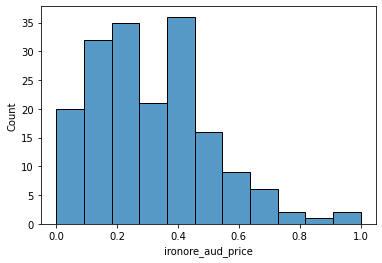

In [30]:
sns.histplot(data=scaled_df, x="ironore_aud_price")

In [31]:
df.reset_index(inplace=True)

In [32]:
df[['ironore_aud_min_max_scaled','copper_aud_min_max_scaled']] = scaled_df[['ironore_aud_price','copper_aud_price']]

## 2.4 Viewing data in terms of bins (reducing noise)

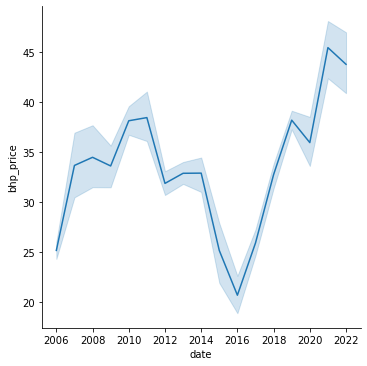

In [33]:
#bhp share price before binning
sns.relplot(x=df['date'].dt.year, y='bhp_price',  kind='line', data=df)

C:\Users\Administrator\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='bhp_price'>

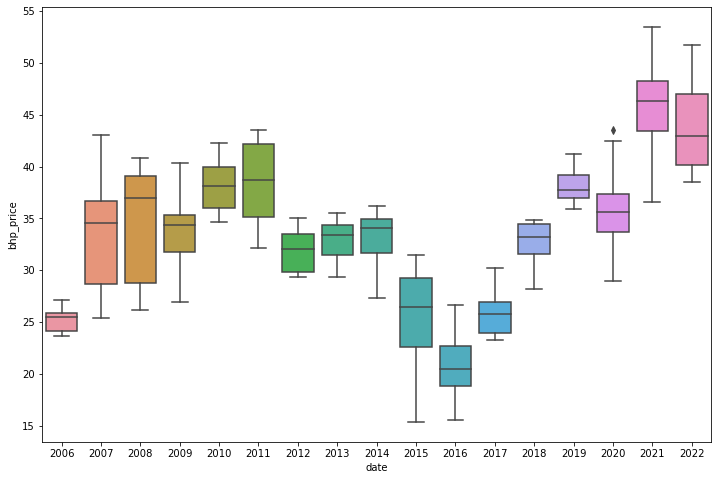

In [34]:
#bhp share price after binning
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.boxplot(df['date'].dt.year, df['bhp_price'])

## 2.5 Detecting outliers

In [35]:
#calculate Z score to detecting the outliers
from scipy import stats
df['bhp_price_zscore']= np.abs(stats.zscore(df['bhp_price']))

<AxesSubplot:xlabel='bhp_price_zscore', ylabel='Count'>

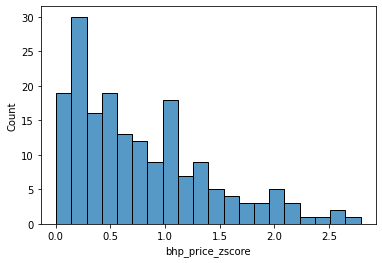

In [36]:
#most of values from histogram are below 2
sns.histplot(data=df, x="bhp_price_zscore",bins=20)

In [37]:
#Select data that have a zscore less than 2
df = df[df['bhp_price_zscore']<2.2]

In [38]:
df.drop(columns=['index'],inplace=True)

In [39]:
df

,date,ironore,copper,bhp_price,aud_to_usd,green_candle,ironore_aud_price,copper_aud_price,normalized_iron_aud,normalized_copper_aud,ironore_aud_min_max_scaled,copper_aud_min_max_scaled,bhp_price_zscore
0,2006-05-01,33.450000,8059.190476,27.098803,0.742777,False,45.033734,10850.087926,0.026221,0.092983,0.022471,0.662155,0.891887
1,2006-06-01,33.450000,7222.772727,25.949438,0.765873,True,43.675665,9430.774289,0.025431,0.080820,0.017138,0.516424,1.052272
2,2006-07-01,33.450000,7726.738095,25.884027,0.763301,False,43.822843,10122.799225,0.025516,0.086751,0.017716,0.587479,1.061400
3,2006-08-01,33.450000,7690.250000,23.949734,0.746491,True,44.809620,10301.858875,0.026091,0.088285,0.021591,0.605865,1.331316
4,2006-09-01,33.450000,7622.642857,25.491562,0.775014,False,43.160535,9835.496037,0.025131,0.084289,0.015115,0.557980,1.116165
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2022-04-01,146.666667,10174.347619,44.610001,0.719520,True,203.839537,14140.461186,0.118688,0.121181,0.646072,1.000000,1.551668
176,2022-05-01,131.090909,9395.027273,41.250000,0.688047,True,190.526214,13654.638537,0.110936,0.117018,0.593793,0.950117,1.082805
177,2022-06-01,131.045455,9067.551818,38.680000,0.700084,True,187.185338,12952.091740,0.108990,0.110997,0.580674,0.877982,0.724181
178,2022-07-01,109.047619,7544.809524,40.599998,0.685740,False,159.021857,11002.437595,0.092592,0.094289,0.470081,0.677798,0.992103


# 3. Data visualisation

In [40]:
df_vis = df[['date','ironore_aud_price','copper_aud_price','green_candle','bhp_price']]

In [41]:
df_vis = df_vis[df_vis['date']>'2006-05']

In [42]:
df_vis['year'] = df_vis['date'].dt.year

In [43]:
df_vis_median = df_vis[['ironore_aud_price','copper_aud_price','bhp_price','year']].groupby('year').mean()

In [44]:
df_vis_median['year'] = df_vis_median.index.astype(str)

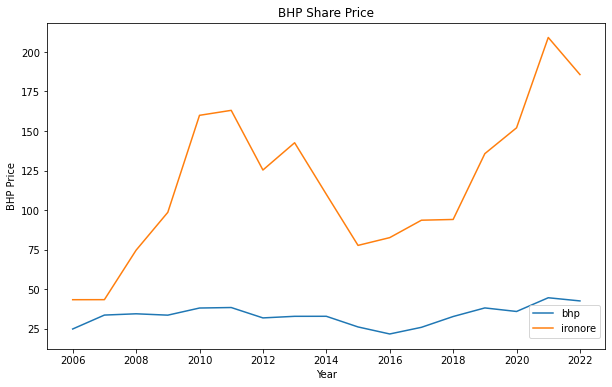

In [45]:
plt.figure(figsize=(10, 6))
plt.plot('bhp_price',data=df_vis_median,label='bhp')
plt.plot('ironore_aud_price',data=df_vis_median,label='ironore')
plt.xlabel('Year')
plt.ylabel('BHP Price')
plt.title('BHP Share Price')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.15), shadow=False, ncol=1)

Text(0.5, 1.0, 'BHP Share Price')

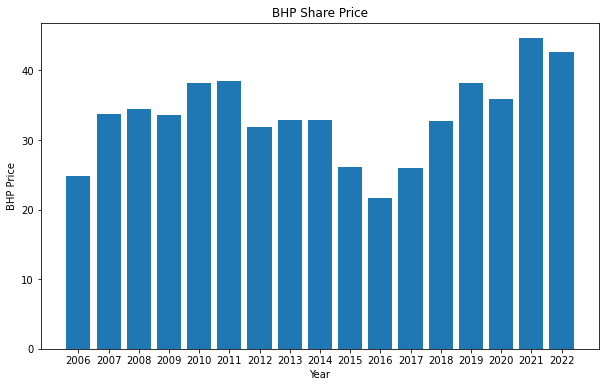

In [46]:
plt.figure(figsize=(10, 6))
plt.bar(x=df_vis_median['year'],height=df_vis_median['bhp_price'],label='bhp')
#plt.bar(x=df_vis_median['year'],height=df_vis_median['ironore_aud_price'],label='ironore')
plt.xlabel('Year')
plt.ylabel('BHP Price')
plt.title('BHP Share Price')
#plt.legend(loc='upper right', bbox_to_anchor=(1, 0.15), shadow=False, ncol=1)

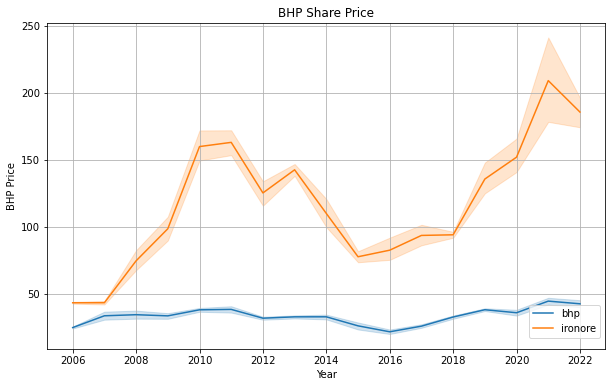

In [47]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='year',y='bhp_price',data=df_vis,label='bhp')
sns.lineplot(x='year',y='ironore_aud_price',data=df_vis,label='ironore')
plt.xlabel('Year')
plt.ylabel('BHP Price')
plt.title('BHP Share Price')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.15), shadow=False, ncol=1)
plt.grid(True)

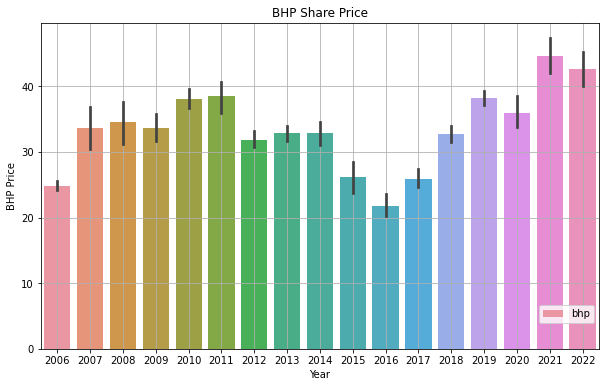

In [48]:
plt.figure(figsize=(10, 6))
sns.barplot(x='year',y='bhp_price',data=df_vis,label='bhp')
#sns.barplot(x='year',y='ironore_aud_price',data=df_vis,label='ironore')
plt.xlabel('Year')
plt.ylabel('BHP Price')
plt.title('BHP Share Price')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.15), shadow=False, ncol=1)
plt.grid(True)

<AxesSubplot:xlabel='year', ylabel='bhp_price'>

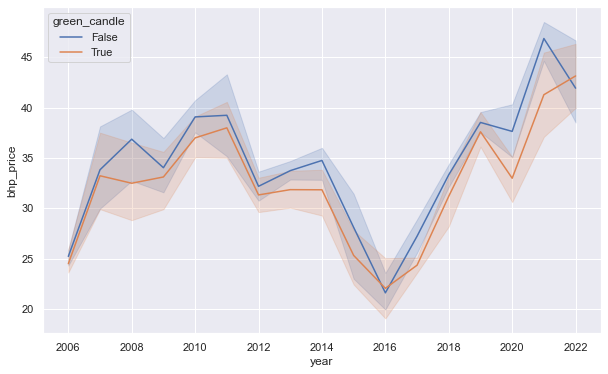

In [49]:
sns.set(rc={'figure.figsize':(10,6)})
sns.lineplot(x='year',y='bhp_price',data=df_vis,hue='green_candle')

<AxesSubplot:xlabel='year', ylabel='bhp_price'>

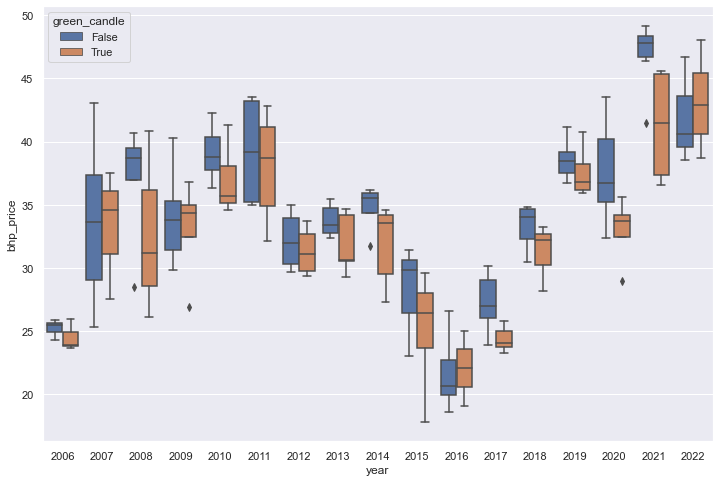

In [50]:
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='year',y='bhp_price',hue='green_candle',data=df_vis)

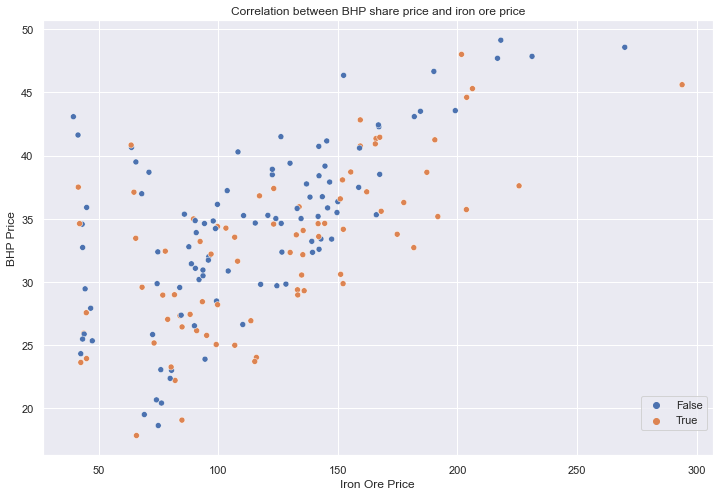

In [51]:
ax = sns.scatterplot(x='ironore_aud_price', y='bhp_price',hue='green_candle',data=df_vis)
ax.set_xlabel('Iron Ore Price')
ax.set_ylabel('BHP Price')
ax.set_title('Correlation between BHP share price and iron ore price')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.15), shadow=False, ncol=1)

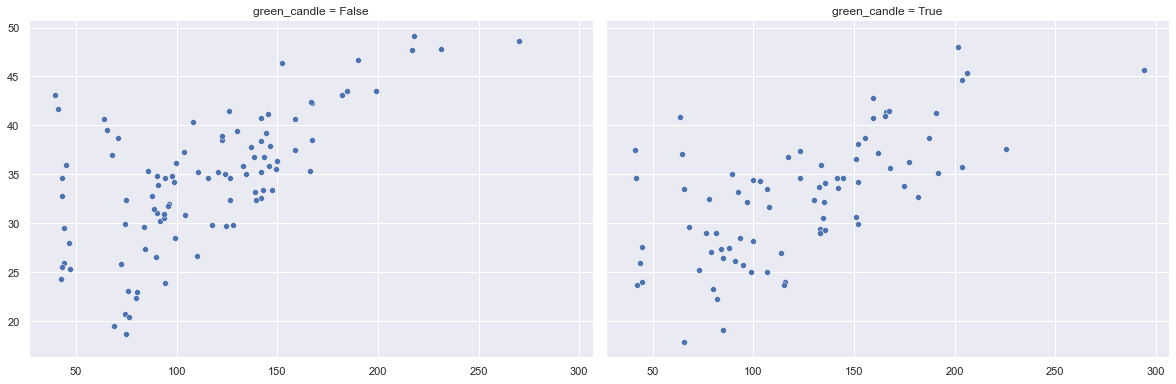

In [52]:
g = sns.FacetGrid(df_vis, col='green_candle',height=5.5, aspect=1.5)
g.map_dataframe(sns.scatterplot, x='ironore_aud_price', y='bhp_price')

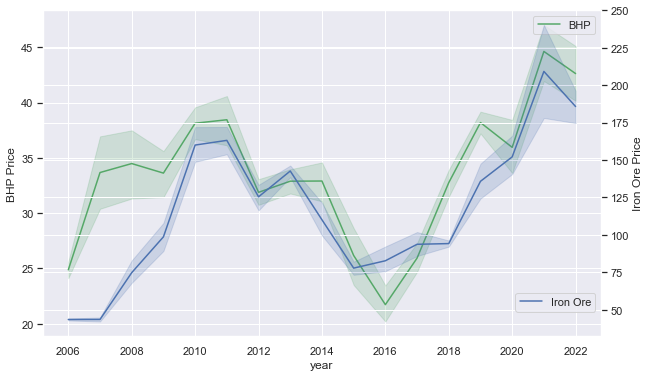

In [53]:
plt.figure(figsize=(10, 6))
ax1 = sns.lineplot(x='year', y='bhp_price', data=df_vis, color='g',label='BHP')
ax1.set_ylabel('BHP Price')
ax3 = plt.twinx()
ax2 = sns.lineplot(x='year', y='ironore_aud_price', data=df_vis, color='b',label='Iron Ore',ax=ax3)
ax2.set_ylabel('Iron Ore Price')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.15), shadow=False, ncol=1)

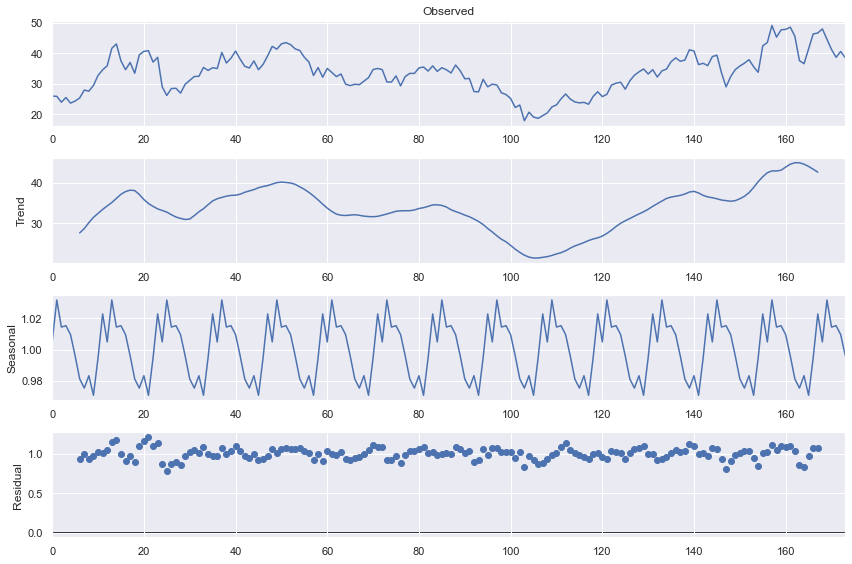

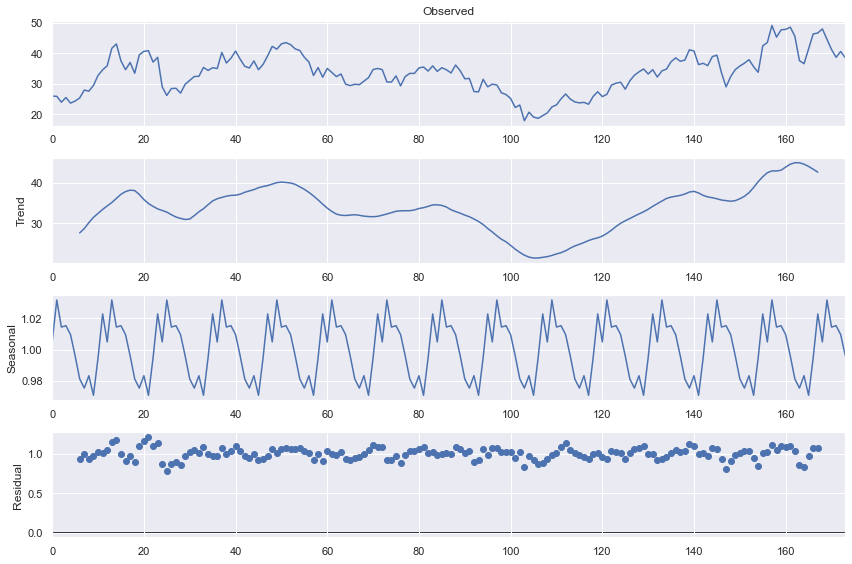

In [54]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(np.array(df_vis['bhp_price']),model='multiplicative', period=12)
res.plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

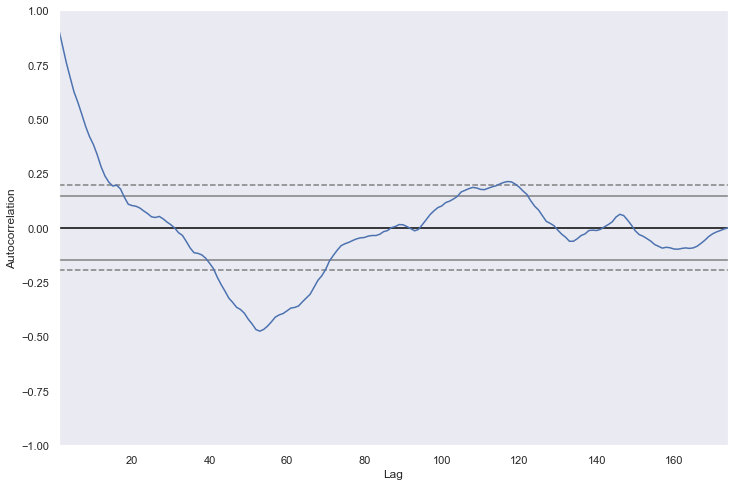

In [55]:
plt.figure(figsize=(12,8))
pd.plotting.autocorrelation_plot(df_vis['bhp_price'])

In [56]:
df_vis['bhp_price'].autocorr(lag=6)

0.6188009616190467

In [57]:
df

,date,ironore,copper,bhp_price,aud_to_usd,green_candle,ironore_aud_price,copper_aud_price,normalized_iron_aud,normalized_copper_aud,ironore_aud_min_max_scaled,copper_aud_min_max_scaled,bhp_price_zscore
0,2006-05-01,33.450000,8059.190476,27.098803,0.742777,False,45.033734,10850.087926,0.026221,0.092983,0.022471,0.662155,0.891887
1,2006-06-01,33.450000,7222.772727,25.949438,0.765873,True,43.675665,9430.774289,0.025431,0.080820,0.017138,0.516424,1.052272
2,2006-07-01,33.450000,7726.738095,25.884027,0.763301,False,43.822843,10122.799225,0.025516,0.086751,0.017716,0.587479,1.061400
3,2006-08-01,33.450000,7690.250000,23.949734,0.746491,True,44.809620,10301.858875,0.026091,0.088285,0.021591,0.605865,1.331316
4,2006-09-01,33.450000,7622.642857,25.491562,0.775014,False,43.160535,9835.496037,0.025131,0.084289,0.015115,0.557980,1.116165
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2022-04-01,146.666667,10174.347619,44.610001,0.719520,True,203.839537,14140.461186,0.118688,0.121181,0.646072,1.000000,1.551668
176,2022-05-01,131.090909,9395.027273,41.250000,0.688047,True,190.526214,13654.638537,0.110936,0.117018,0.593793,0.950117,1.082805
177,2022-06-01,131.045455,9067.551818,38.680000,0.700084,True,187.185338,12952.091740,0.108990,0.110997,0.580674,0.877982,0.724181
178,2022-07-01,109.047619,7544.809524,40.599998,0.685740,False,159.021857,11002.437595,0.092592,0.094289,0.470081,0.677798,0.992103


# 4. Data modelling

In [85]:
df_model = df[['date','ironore_aud_min_max_scaled','copper_aud_min_max_scaled','green_candle','bhp_price']]

In [86]:
df_model['green_candle'] = pd.get_dummies(df_model['green_candle'])[True]

<ipython-input-86-f63901c87afa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['green_candle'] = pd.get_dummies(df_model['green_candle'])[True]


In [87]:
df_model.set_index('date',inplace=True)

In [88]:
df_model['bhp_pct'] = df_model['bhp_price'].pct_change(periods=1)

<ipython-input-88-539c8754e4ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['bhp_pct'] = df_model['bhp_price'].pct_change(periods=1)


In [89]:
columns_lag = ['ironore_aud_min_max_scaled','copper_aud_min_max_scaled','bhp_price','bhp_pct','green_candle']
nums_lag = 3

In [90]:
for column in columns_lag:
    for num in np.arange(nums_lag):
        df_model['t-'+str(num+1)+'_'+str(column)] = df_model[column].shift(num+1)

<ipython-input-90-9aa52c61a4ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['t-'+str(num+1)+'_'+str(column)] = df_model[column].shift(num+1)


In [91]:
column_predict = 'bhp_price'
nums_predict = 3

In [92]:
for num in np.arange(nums_predict):
    df_model['t+'+str(num+1)+'_'+str(column_predict)] = df_model[column_predict].shift(-num-1)

In [93]:
df_model.columns

Index(['ironore_aud_min_max_scaled', 'copper_aud_min_max_scaled',
       'green_candle', 'bhp_price', 'bhp_pct',
       't-1_ironore_aud_min_max_scaled', 't-2_ironore_aud_min_max_scaled',
       't-3_ironore_aud_min_max_scaled', 't-1_copper_aud_min_max_scaled',
       't-2_copper_aud_min_max_scaled', 't-3_copper_aud_min_max_scaled',
       't-1_bhp_price', 't-2_bhp_price', 't-3_bhp_price', 't-1_bhp_pct',
       't-2_bhp_pct', 't-3_bhp_pct', 't-1_green_candle', 't-2_green_candle',
       't-3_green_candle', 't+1_bhp_price', 't+2_bhp_price', 't+3_bhp_price'],
      dtype='object')

In [95]:
df_model.dropna(inplace=True)

In [96]:
df_model

,ironore_aud_min_max_scaled,copper_aud_min_max_scaled,green_candle,bhp_price,bhp_pct,t-1_ironore_aud_min_max_scaled,t-2_ironore_aud_min_max_scaled,t-3_ironore_aud_min_max_scaled,t-1_copper_aud_min_max_scaled,t-2_copper_aud_min_max_scaled,...,t-3_bhp_price,t-1_bhp_pct,t-2_bhp_pct,t-3_bhp_pct,t-1_green_candle,t-2_green_candle,t-3_green_candle,t+1_bhp_price,t+2_bhp_price,t+3_bhp_price
date,,,,,,,,,,,,,,,,,,,,,
2006-09-01,0.015115,0.557980,0,25.491562,0.064378,0.021591,0.017716,0.017138,0.605865,0.587479,...,25.949438,-0.074729,-0.002521,-0.042414,1.0,0.0,1.0,23.641369,24.332855,25.351397
2006-11-01,0.012199,0.463348,1,23.641369,-0.072581,0.015115,0.021591,0.017716,0.557980,0.605865,...,25.884027,0.064378,-0.074729,-0.002521,0.0,1.0,0.0,24.332855,25.351397,27.930454
2006-12-01,0.012147,0.417721,0,24.332855,0.029249,0.012199,0.015115,0.021591,0.463348,0.557980,...,23.949734,-0.072581,0.064378,-0.074729,1.0,0.0,1.0,25.351397,27.930454,27.575367
2007-01-01,0.031069,0.301206,0,25.351397,0.041859,0.012147,0.012199,0.015115,0.417721,0.463348,...,25.491562,0.029249,-0.072581,0.064378,0.0,1.0,0.0,27.930454,27.575367,29.462938
2007-02-01,0.028379,0.294040,0,27.930454,0.101732,0.031069,0.012147,0.012199,0.301206,0.417721,...,23.641369,0.041859,0.029249,-0.072581,0.0,0.0,1.0,27.575367,29.462938,32.733482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,0.443913,0.900808,0,46.349998,0.116867,0.340929,0.438537,0.732123,0.946032,0.819322,...,37.610001,0.134500,-0.027386,-0.175400,0.0,1.0,1.0,46.660000,48.009998,44.610001
2022-01-01,0.592195,0.983398,0,46.660000,0.006688,0.443913,0.340929,0.438537,0.900808,0.946032,...,36.580002,0.116867,0.134500,-0.027386,0.0,0.0,1.0,48.009998,44.610001,41.250000
2022-03-01,0.637603,0.985944,1,48.009998,0.028933,0.592195,0.443913,0.340929,0.983398,0.900808,...,41.500000,0.006688,0.116867,0.134500,0.0,0.0,0.0,44.610001,41.250000,38.680000


In [101]:
# train test split
df_train = df_model[pd.to_datetime(df_model.index,format='%Y-%m').year < 2021]
df_test = df_model[pd.to_datetime(df_model.index,format='%Y-%m').year >= 2021]

In [70]:
from sklearn.linear_model import LinearRegression

In [105]:
columns_train = ['t-1_bhp_price','t-2_bhp_price','t-3_bhp_price']
column_target = 't+3_bhp_price'
bhp_model = LinearRegression().fit(df_train[columns_train], df_train[column_target])
np.mean(abs(bhp_model.predict(df_test[columns_train])-df_test[column_target]))

5.348972006531822

<AxesSubplot:xlabel='date', ylabel='t+3_bhp_price'>

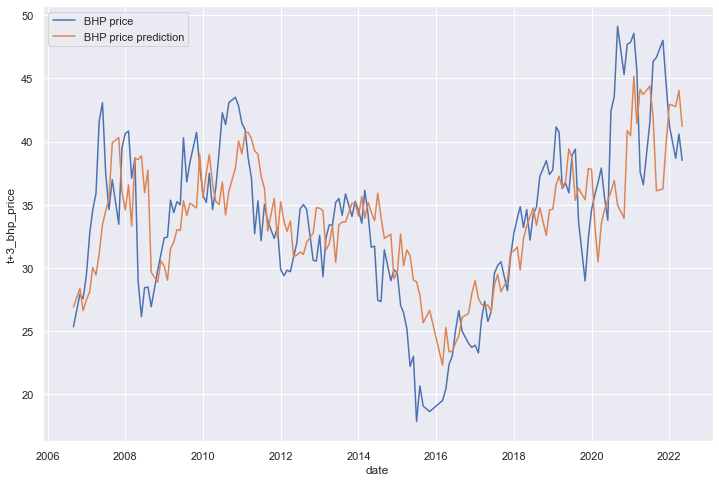

In [106]:
sns.lineplot(x=df_model.index,y=df_model[column_target],label='BHP price')
sns.lineplot(x=df_model.index,y=bhp_model.predict(df_model[columns_train]),label='BHP price prediction')

In [107]:
columns_train = ['t-1_bhp_price','t-2_bhp_price','t-3_bhp_price','t-1_bhp_pct','t-2_bhp_pct','t-3_bhp_pct']
column_target = 't+3_bhp_price'
bhp_model = LinearRegression().fit(df_train[columns_train], df_train[column_target])
np.mean(abs(bhp_model.predict(df_test[columns_train])-df_test[column_target]))

4.85233459863631

<AxesSubplot:xlabel='date', ylabel='t+3_bhp_price'>

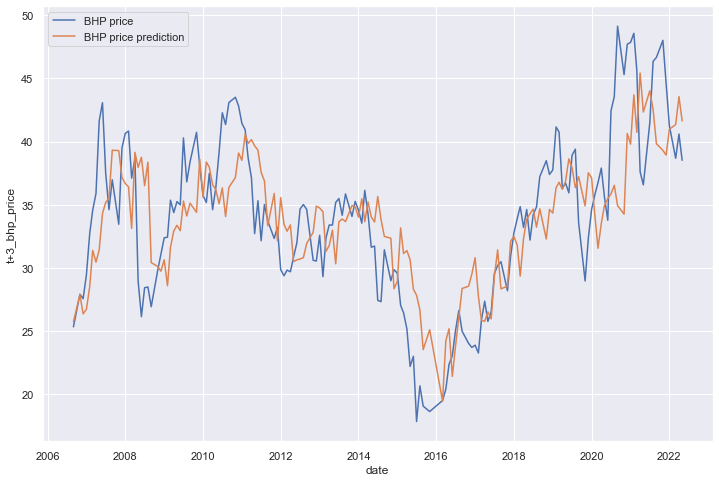

In [108]:
sns.lineplot(x=df_model.index,y=df_model[column_target],label='BHP price')
sns.lineplot(x=df_model.index,y=bhp_model.predict(df_model[columns_train]),label='BHP price prediction')

In [109]:
columns_train = ['t-1_bhp_price','t-2_bhp_price','t-3_bhp_price','t-1_bhp_pct','t-2_bhp_pct','t-1_ironore_aud_min_max_scaled','t-2_ironore_aud_min_max_scaled']
column_target = 't+3_bhp_price'
bhp_model = LinearRegression().fit(df_train[columns_train], df_train[column_target])
np.mean(abs(bhp_model.predict(df_test[columns_train])-df_test[column_target]))

4.7288752917840355

<AxesSubplot:xlabel='date', ylabel='t+3_bhp_price'>

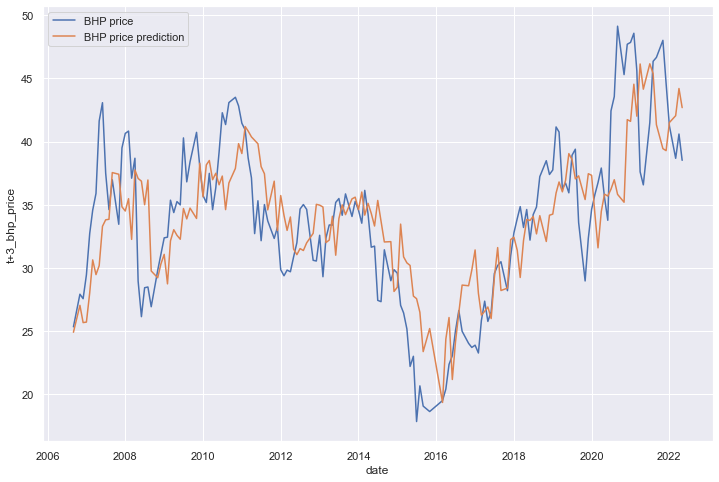

In [110]:
sns.lineplot(x=df_model.index,y=df_model[column_target],label='BHP price')
sns.lineplot(x=df_model.index,y=bhp_model.predict(df_model[columns_train]),label='BHP price prediction')

In [111]:
from sklearn.tree import DecisionTreeRegressor

In [112]:
columns_train = ['t-1_bhp_price','t-2_bhp_price','t-3_bhp_price','t-1_bhp_pct','t-2_bhp_pct','t-1_ironore_aud_min_max_scaled','t-2_ironore_aud_min_max_scaled']
column_target = 't+3_bhp_price'

In [113]:
for i in range(1,15):
    treemodel = DecisionTreeRegressor(max_depth = i)
    treemodel = treemodel.fit(df_train[columns_train], df_train[column_target])
    print('Tree level:',i," error:",np.mean(abs(treemodel.predict(df_test[columns_train])-df_test[column_target])))

Tree level: 1  error: 7.8934537263800495
Tree level: 2  error: 5.596670017603974
Tree level: 3  error: 5.505461230503305
Tree level: 4  error: 4.476561933221386
Tree level: 5  error: 5.078925751067778
Tree level: 6  error: 5.346936907087054
Tree level: 7  error: 4.655450616564069
Tree level: 8  error: 4.6567226591564355
Tree level: 9  error: 4.983065741402762
Tree level: 10  error: 4.5403706686837335
Tree level: 11  error: 4.591036932809012
Tree level: 12  error: 5.836202893938337
Tree level: 13  error: 4.876940046037946
Tree level: 14  error: 4.62976210457938


In [114]:
from sklearn import tree

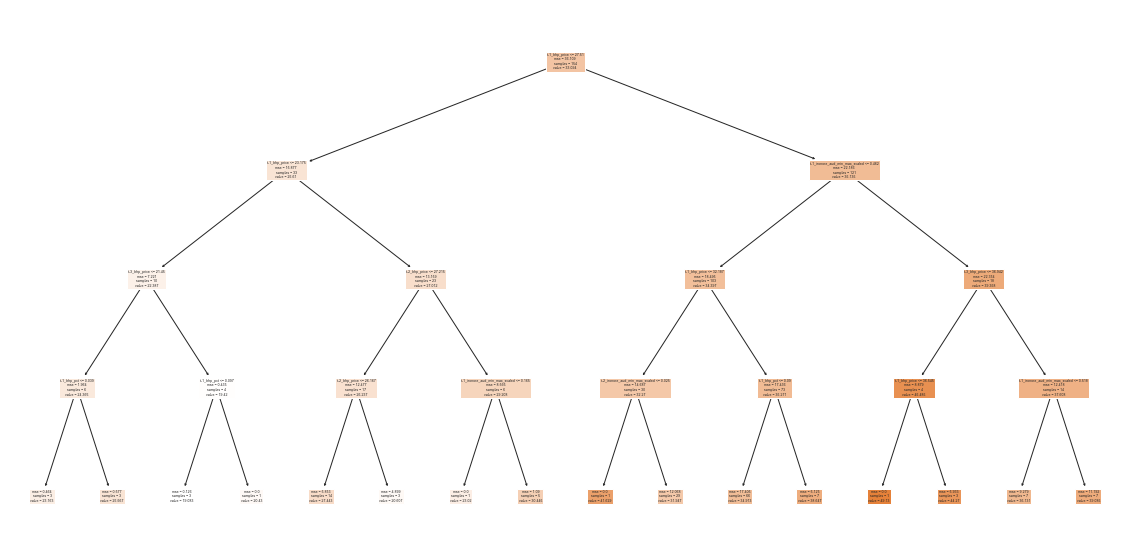

In [115]:
treemodel = DecisionTreeRegressor(max_depth = 4)
treemodel = treemodel.fit(df_train[columns_train], df_train[column_target])
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(treemodel, feature_names=columns_train,filled=True)